In [1]:
##Tools
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
#creating the tools

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("What is latest research on quantum computing")

'Published: 2021-05-31\nTitle: Quantum computing hardware in the cloud: Should a computational chemist care?\nAuthors: A. Rossi, P. G. Baity, V. M. Schäfer, M. Weides\nSummary: Within the last decade much progress has been made in the experimental\nrealisation of quantum computing hardware based on a variety of physical\nsystems. Rapid progress has been fuelled by the conviction that sufficiently\npowerful quantum machines will herald enormous computational advantages in many\nfields, including chemical'

In [4]:
#wikipedia
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results = 1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper= api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")


In [6]:
##Tavily seach tool (internet tool)
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [7]:
tavily.invoke("Provide me the recent AI news?")

[{'url': 'https://www.artificialintelligence-news.com/',
  'content': 'March 4, 2025\nAutoscience Carl: The first AI scientist writing peer-reviewed papers\nApplications\nMarch 3, 2025\nDeep Learning\nAlibaba Qwen QwQ-32B: Scaled reinforcement learning showcase\nArtificial Intelligence\nMarch 6, 2025\nDeepSeek-R1 reasoning models rival OpenAI in performance\nArtificial Intelligence\nJanuary 20, 2025\nNew AI training techniques aim to overcome current challenges\nDeep & Reinforcement Learning\nNovember 28, 2024 [...] Artificial Intelligence\nMarch 14, 2025\nOpenAI and Google call for US government action to secure AI lead\n\nArtificial Intelligence\nMarch 14, 2025\nCBRE: Leveraging Artificial Intelligence for business growth\n\nAGI\nMarch 14, 2025\nManus AI agent: breakthrough in China’s agentic AI\n\nApplications\nMarch 13, 2025\nServiceNow deploys AI agents to boost enterprise workflows [...] AI News\nMarch 20, 2025\nUK minister in US to pitch Britain as global AI investment hub\n\nTe

In [8]:
##Combine all these tools in list
tools = [arxiv,wiki,tavily]

In [9]:
#Initialize the LLM Model
from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen-qwq-32b")

In [10]:
llm.invoke("What is AI?")

AIMessage(content='\n<think>\nOkay, so I need to explain what AI is. Let\'s start with the basics. AI stands for Artificial Intelligence. From what I remember, it\'s a field of computer science that deals with creating machines or software that can perform tasks that typically require human intelligence. But wait, that\'s pretty broad. Maybe I should break it down into different types.\n\nThere\'s something called general AI, which is like human-level intelligence where machines can handle any intellectual task a human can. But I think that\'s still theoretical and not really achieved yet. Then there\'s narrow AI, which is the type we see today, like voice assistants, recommendation systems, or image recognition. Those are good at specific tasks but can\'t do much else.\n\nHmm, how do these systems work? I think machine learning is a subset of AI. So AI uses algorithms and data to learn and make decisions. Neural networks, maybe? Those are inspired by the human brain. They have layers 

In [11]:
llm_with_tools = llm.bind_tools(tools = tools)

In [13]:
#Execute this call
llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_j88c', 'function': {'arguments': '{"query": "recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 233, 'prompt_tokens': 356, 'total_tokens': 589, 'completion_time': 0.564066341, 'prompt_time': 0.024911058, 'queue_time': 1.459429398, 'total_time': 0.588977399}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a56ada6e3f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-abb5b7d1-a30a-4553-b350-1168afce27f2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'call_j88c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 356, 'output_tokens': 233, 'total_tokens': 589})

## Workflow

In [14]:
#State Schema
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage #Human msg or AI msg
from typing import Annotated #labelling
from langgraph.graph.message import add_messages ##Reducers in Langgraph


In [15]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    #add_messages it will not override inside this particular variable instead it will append messages inside this particular variable and 
    #return type will be date.


In [16]:
### Entire Chatbot with langraph
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

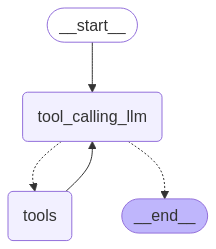

In [21]:
def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

##Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    #If the latest message (result) from assistant is a tool call --> tools_condition routes to tool by default
    #If the latest message (result) from assistant is not a tool call --> tools_condition routes to tool
tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages = graph.invoke({"messages": "1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_6gn3)
 Call ID: call_6gn3
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
================================== Ai Message ==================================

It seems like you're looking at the seminal 2017 paper introducing 

In [23]:
messages = graph.invoke({"messages": "My name is rageswari"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My name is rageswari
================================== Ai Message ==================================

Hello Rageswari! Nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you'd like help finding information! 😊


In [24]:
messages = graph.invoke({"messages": "My name is rageswari and please tell me the recent research paper on quantum computing?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My name is rageswari and please tell me the recent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_m8vs)
 Call ID: call_m8vs
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: arxiv

Published: 2022-08-01
Title: The Rise of Quantum Internet Computing
Authors: Seng W. Loke
Summary: This article highlights quantum Internet computing as referring to
distributed quantum computing over the quantum Internet, analogous to
(classical) Internet computing involving (classical) distributed computing over
the (classical) Internet. Relevant to quantum Internet computing would be areas
of study such as quantum protocols for distributed nodes using quantum
information for computations, qua
================================== Ai Message ===================

In [25]:
messages = graph.invoke({"messages": "What is recent AI news and then please tell me the recent research paper on quantum computing?"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is recent AI news and then please tell me the recent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_xfyq)
 Call ID: call_xfyq
  Args:
    query: recent AI news
  arxiv (call_xm8n)
 Call ID: call_xm8n
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.artificialintelligence-news.com/", "content": "March 4, 2025\nAutoscience Carl: The first AI scientist writing peer-reviewed papers\nApplications\nMarch 3, 2025\nDeep Learning\nAlibaba Qwen QwQ-32B: Scaled reinforcement learning showcase\nArtificial Intelligence\nMarch 6, 2025\nDeepSeek-R1 reasoning models rival OpenAI in performance\nArtificial Intelligence\nJanuary 20, 2025\nNew AI training techniques aim to overcom